In [1]:
import mesa
import numpy as np
import matplotlib.pyplot as plt

from Model_Ilya_Play import *

### Trying new features of the model

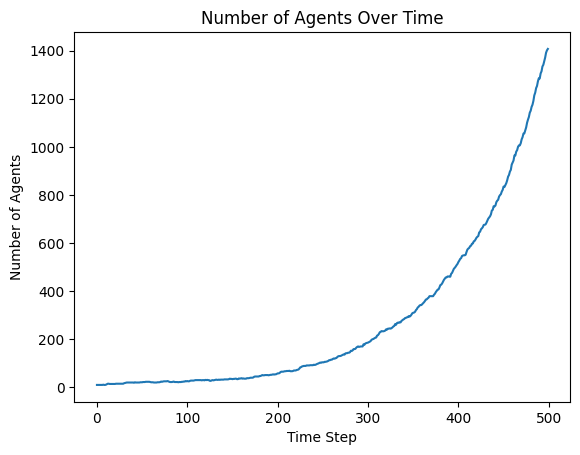

In [2]:
#Making x steps with in the model
x = 500

model = Microbiome(10, 0, False, 50, 50)
for i in range(x):
    model.step()

# Check the numbers of agents

agent_num_data = model.datacollector.get_model_vars_dataframe()
num_of_agents = agent_num_data.loc[:,"Type_a_1"]
number_of_time_steps = agent_num_data.index

# Plotting the number of agents over time
plt.plot(number_of_time_steps, num_of_agents)

# Adding labels and title
plt.xlabel('Time Step')
plt.ylabel('Number of Agents')
plt.title('Number of Agents Over Time')

# Displaying the plot
plt.show()

In [6]:
50*50*5

12500

In [38]:
# Extract the data about mass of one of the bacteria
my_variable_view = []

my_agents = [agent for agent in model.schedule.agents if isinstance(agent, Type_a_2)]
for agent in my_agents:

    my_vars = []
     
    # Acess the variables of the current agent
    my_vars.append(agent.mass)
    # my_vars.append(agent.split_mass)
    # my_vars.append(agent.min_mass)
    my_vars.append(agent.energy_netto)
    # my_vars.append(agent.max_viability_time)
    # my_vars.append(agent.viability_index)

    my_variable_view.append(float(agent.energy_netto))

    #print(f"{agent.unique_id}:{my_vars}")
    # Print the unique ID and variable of the current agent
    # if agent.mass < 85:
    #     print(f"{agent.unique_id}:{my_vars}")



In [29]:
len(my_variable_view)

11268

In [39]:
my_variable_view


[1.0534932697423507,
 1.4370595518284688,
 4.000488508447162,
 7.796818342765917,
 2.3464065815100383,
 2.706955982625793,
 2.4437752159883424,
 3.5204894164156677,
 4.745326774908044,
 7.504299251429568,
 1.9116640723967393,
 3.6632360627769316,
 8.335576439899214,
 1.8552053760197786,
 3.3841660604561206,
 8.36459400685468,
 7.807200274666176,
 6.689745194409145,
 3.280475249856245,
 2.850146185525521,
 4.733707818718386,
 2.7680050420903406,
 5.9536152940143054,
 5.505778572169252,
 6.952126713204098,
 7.971404965586153,
 8.858660521429421,
 5.132953514224898,
 6.20633505975583,
 4.505186510586508,
 1.8274344648161787,
 2.688339162439604,
 2.1446540362967355,
 4.576535542791724,
 10.797835907979369,
 6.5397435945099645,
 4.1286154417383045,
 9.0580637905971,
 0.4045261793141126,
 15.234089380420173,
 7.4763822177552655,
 9.442381819333082,
 1.5740894086895807,
 5.245166824126308,
 5.859526525720504,
 5.669801114129424,
 5.039990338984303,
 6.311501363090393,
 8.199416631236726,
 2.8

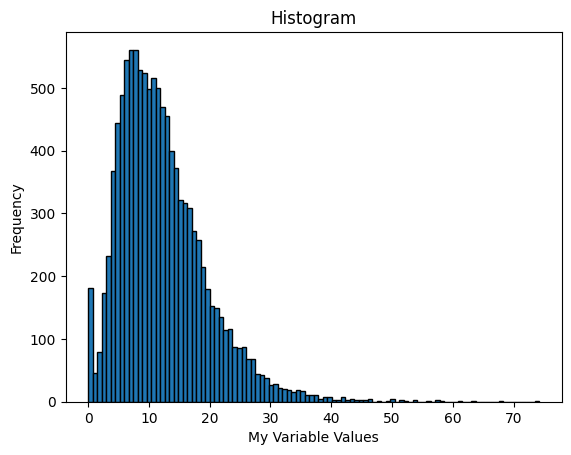

In [41]:
plt.hist(my_variable_view, bins=100, edgecolor='black')

# Adding labels and title
plt.xlabel('My Variable Values')
plt.ylabel('Frequency')
plt.title('Histogram')

# Displaying the histogram
plt.show()